In [1]:
library(tidyverse)
library(cowplot)
library(ggExtra)
library(ggbeeswarm)
library(ggrepel)

`%+replace%` <- ggplot2::`%+replace%`

theme_zietzm <- function(base_size = 11.5, base_family = "") {
    # Starts with theme_bw and then modify some parts
    # Theme options are documentated at http://docs.ggplot2.org/current/theme.html
    ggplot2::theme_classic(base_size = base_size, base_family = base_family) %+replace%
    ggplot2::theme(

        strip.background  = ggplot2::element_rect(fill = NA, colour = 'grey90', size = 0),
        strip.text = element_text(vjust = 1, size = 10),
        plot.margin       = ggplot2::margin(t=2, r=2, b=2, l=2, unit='pt'),
        legend.spacing     = grid::unit(0.1, 'cm'),
        legend.key        = ggplot2::element_blank(),
        panel.border=element_rect(fill = NA, color = 'black', size = 0.5), 
        axis.line=element_line(size=0),
    )
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



In [2]:
unperm_df <- bind_rows(
        read_tsv('../../data//task1/full_priors/AlD.tsv.gz') %>% mutate(metaedge = 'Disease→localized→Anatomy'),
        read_tsv('../../data//task1/full_priors/CrC.tsv.gz') %>% mutate(metaedge = 'Compound–resembles–Compound'),
        read_tsv('../../data//task1/full_priors/DuG.tsv.gz') %>% mutate(metaedge = 'Disease→regulates→Gene'),
    ) %>%
    group_by(metaedge) %>%
    mutate(
        approx = source_degree * target_degree / sqrt(
            (source_degree * target_degree) ^ 2 + (sum(edge) - source_degree - target_degree + 1) ^ 2
        ),
        scaled_degree = source_degree * target_degree / max(source_degree * target_degree),
    ) %>%
    ungroup() %>%
    gather('prior', 'value', approx, scaled_degree)

unperm_df %>% head

Parsed with column specification:
cols(
  source_id = col_double(),
  target_id = col_double(),
  edge = col_logical(),
  source_degree = col_double(),
  target_degree = col_double(),
  xswap_prior = col_double()
)
Parsed with column specification:
cols(
  source_id = col_double(),
  target_id = col_double(),
  edge = col_logical(),
  source_degree = col_double(),
  target_degree = col_double(),
  xswap_prior = col_double()
)
Parsed with column specification:
cols(
  source_id = col_double(),
  target_id = col_double(),
  edge = col_logical(),
  source_degree = col_double(),
  target_degree = col_double(),
  xswap_prior = col_double()
)


source_id,target_id,edge,source_degree,target_degree,xswap_prior,metaedge,prior,value
<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
0,0,FALSE,7,4,0.006785714,Disease→localized→Anatomy,approx,0.007794863
0,1,FALSE,7,16,0.031190476,Disease→localized→Anatomy,approx,0.031269617
0,2,FALSE,7,37,0.079285714,Disease→localized→Anatomy,approx,0.072581311
0,3,FALSE,7,4,0.006785714,Disease→localized→Anatomy,approx,0.007794863
0,4,FALSE,7,0,0.000000000,Disease→localized→Anatomy,approx,0.000000000
0,5,FALSE,7,58,0.116428571,Disease→localized→Anatomy,approx,0.114005910


In [3]:
prior_approx <- unperm_df %>%
group_by(metaedge) %>%
sample_n(10000) %>%
mutate(
    prior = prior %>% recode_factor(
        approx = 'Analytical approximation',
        scaled_degree = 'Scaled degree'
    )
) %>%
ungroup() %>%
ggplot(aes(x = xswap_prior, y = value)) +
geom_point(alpha = 0.3) + 
geom_abline(color = 'grey', linetype = 'dashed') +
facet_grid(cols = vars(metaedge), rows = vars(prior), scales = 'free') +
theme_zietzm() +
ylab('Feature value') +
xlab('Edge prior')

In [4]:
prior_approx_df <- unperm_df %>%
filter(prior == 'approx') %>%
group_by(metaedge) %>%
sample_n(10000) %>%
ungroup() %>%
mutate(
    metaedge = metaedge %>% factor(levels = c('Disease→localized→Anatomy',
                                              'Compound–resembles–Compound',
                                              'Disease→regulates→Gene'))
) 

prior_approx_df %>% write_tsv("../../data/3_prior_vs_approx.tsv")

prior_approx <- prior_approx_df %>%
ggplot(aes(x = xswap_prior, y = value)) +
geom_point(alpha = 0.1) + 
geom_abline(color = 'grey', linetype = 'dashed') +
facet_wrap(vars(metaedge), scales = 'free') +
theme_zietzm() +
xlab('Edge prior') +
ylab('Analytical approximation') +
# coord_equal() +
scale_y_continuous(trans = 'log10', breaks = c()) + 
scale_x_continuous(trans = 'log10', breaks = c(0.001, 0.01, 0.1))

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous x-axis”

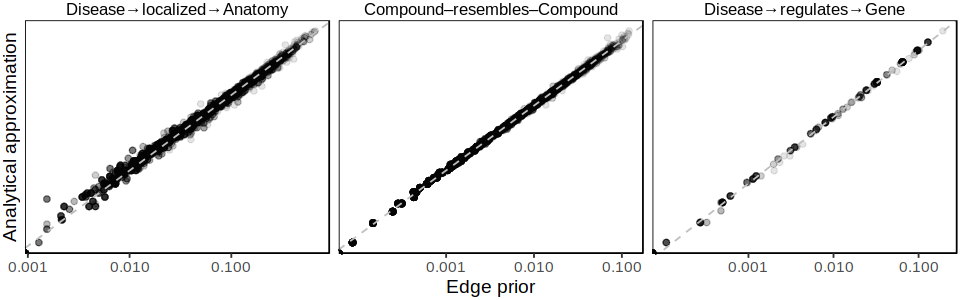

In [5]:
options(repr.plot.width=8, repr.plot.height=2.5)

ggsave('../../img/prior_exact_vs_approx.png', prior_approx, width = 8, height = 2.5, dpi = 400)

prior_approx